In [53]:
import pandas as pd
from pyspark.sql import SparkSession, functions as F
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import seaborn as sns
import numpy as np

In [54]:
# Create a spark session
spark = (
    SparkSession.builder.appName("Predict fraud probabilities")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "8g")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

In [55]:
spark.read.parquet('../../../data/curated/process_data.parquet').printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- consumer_id: long (nullable = true)
 |-- user_id: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- merchant_name: string (nullable = true)
 |-- tag: string (nullable = true)
 |-- revenue: string (nullable = true)
 |-- rate: double (nullable = true)
 |-- category: string (nullable = true)
 |-- subcategory: string (nullable = true)
 |-- merchant_fraud_probability: double (nullable = true)
 |-- user_fraud_probability: double (nullable = true)
 |-- estimated_region_population_2021_sum: long (nullable = true)
 |-- persons_earners_2018-19_sum: double (nullable = true)
 |-- mean_earnings_2018-19_avg: double (nullable = true)
 |-- sum_earnings_2018-19_sum: double (nullable = true)
 |-- median_earnings_2018-19_avg: double (n

In [56]:
# these are our predictors
base_features = {'dollar_value',
                 #'postcode',
                 'gender',
                 'revenue',
                 'rate'}

target_feature = {'user_fraud_probability'}

subset = base_features.union(target_feature)
print(subset)

{'dollar_value', 'rate', 'gender', 'revenue', 'user_fraud_probability'}


In [57]:
raw = spark.read.parquet('../../../data/curated/process_data.parquet').select(*subset)
raw = raw.na.drop(subset=['user_fraud_probability']) 

-> to Pandas to visualise

In [58]:
pdf = raw.toPandas()
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71636 entries, 0 to 71635
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   dollar_value            71636 non-null  float64
 1   rate                    71636 non-null  float64
 2   gender                  71636 non-null  object 
 3   revenue                 71636 non-null  object 
 4   user_fraud_probability  71636 non-null  float64
dtypes: float64(3), object(2)
memory usage: 2.7+ MB


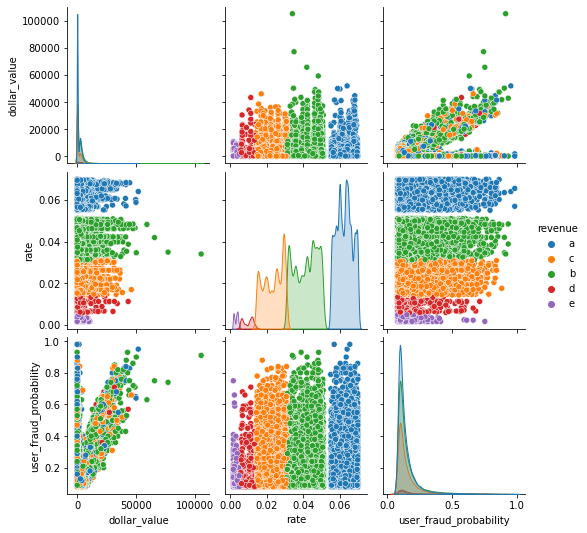

In [59]:
sns.pairplot(pdf, hue='revenue')

<AxesSubplot:>

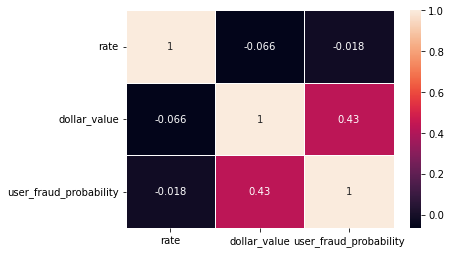

In [60]:
sns.heatmap(pdf[['rate', 'dollar_value', 'user_fraud_probability']].corr(), annot=True, lw=1)

<AxesSubplot:>

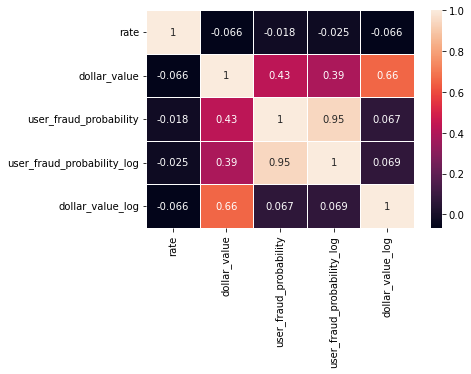

In [61]:
# investigate log relationships
pdf['user_fraud_probability_log'] = pdf['user_fraud_probability'].map(lambda x: np.log(x))
pdf['dollar_value_log'] = pdf['dollar_value'].map(lambda x: np.log(x))
sns.heatmap(pdf[['rate', 'dollar_value', 'user_fraud_probability', 'user_fraud_probability_log', 'dollar_value_log']].corr(), annot=True, lw=1)

Try and fit a model

In [62]:
categorical_cols = {'gender','revenue'}
continous_cols = {'dollar_value', 'rate'} # ,'merchant_fraud_probability'

In [140]:
def get_dummy(df,categoricalCols,continuousCols,labelCol):

    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
    from pyspark.sql.functions import col

    from pyspark.ml.feature import RobustScaler
    #from pyspark.ml.feature import StandardScaler
    
    
    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in categoricalCols ]

    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                               outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers ]

    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                          + continuousCols, outputCol="features")

    #scaler = RobustScaler(inputCol='features',outputCol='features_std')
    #scaler = StandardScaler(inputCol='features',outputCol='features_std')
    
    
    #pipeline = Pipeline(stages=indexers + encoders + [assembler] + [scaler])
    pipeline = Pipeline(stages=indexers + encoders + [assembler])

    model=pipeline.fit(df)
    data = model.transform(df)

    data = data.withColumnRenamed(labelCol, 'label')
    
    return data.select('features','label', 'weights')
    #return data.select('features_std','label').withColumnRenamed('features_std', 'features')

In [64]:
data = get_dummy(raw, list(categorical_cols), list(continous_cols), labelCol='user_fraud_probability')

In [65]:
(trainingData, testData) = data.randomSplit([0.7, 0.3])

In [66]:
gbt = GBTRegressor(labelCol='label',
                   #featuresCol="features_std",
                   featuresCol="features",
                   maxIter=20,
                   maxDepth=10,
                   seed=56,
                   lossType='squared')

In [68]:
import time
start = time.time()
model = gbt.fit(trainingData)
#model = glr.fit(trainingData)
print('fitting model took {0} seconds on {1} rows'.format(time.time()-start,
                                                          trainingData.count()))

22/10/06 11:33:28 WARN DAGScheduler: Broadcasting large task binary with size 1003.4 KiB
22/10/06 11:33:29 WARN DAGScheduler: Broadcasting large task binary with size 1000.8 KiB
22/10/06 11:33:29 WARN DAGScheduler: Broadcasting large task binary with size 1009.5 KiB
22/10/06 11:33:29 WARN DAGScheduler: Broadcasting large task binary with size 1024.5 KiB
22/10/06 11:33:29 WARN DAGScheduler: Broadcasting large task binary with size 1047.5 KiB
22/10/06 11:33:29 WARN DAGScheduler: Broadcasting large task binary with size 1080.3 KiB
22/10/06 11:33:29 WARN DAGScheduler: Broadcasting large task binary with size 1064.1 KiB
22/10/06 11:33:29 WARN DAGScheduler: Broadcasting large task binary with size 1064.5 KiB
22/10/06 11:33:29 WARN DAGScheduler: Broadcasting large task binary with size 1065.3 KiB
22/10/06 11:33:29 WARN DAGScheduler: Broadcasting large task binary with size 1066.3 KiB
22/10/06 11:33:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.6 KiB
22/10/06 11:33:30 WAR

fitting model took 36.54531979560852 seconds on 50112 rows


Evaluate:

In [75]:
predictions = model.transform(testData)

In [76]:
rmse_evaluator = RegressionEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="rmse")
rmse = rmse_evaluator.evaluate(predictions)

mae_evaluator = RegressionEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="mae")
mae = mae_evaluator.evaluate(predictions)

print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print("Mean Average Error (MAE) on test data = %g" % mae)

Root Mean Squared Error (RMSE) on test data = 0.079823
Mean Average Error (MAE) on test data = 0.0468514


In [77]:
res = predictions.select(['prediction', 'label']).toPandas()

<AxesSubplot:>

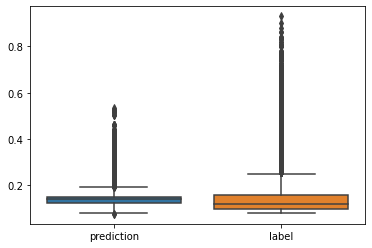

In [78]:
sns.boxplot(data=res)

<AxesSubplot:xlabel='prediction', ylabel='Count'>

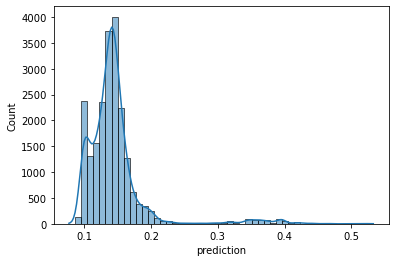

In [79]:
#sns.histplot(x='prediction', data=res[res['prediction'] <= 1], kde=True)
sns.histplot(x='prediction', data=res, kde=True, bins=50)

<AxesSubplot:xlabel='label', ylabel='Count'>

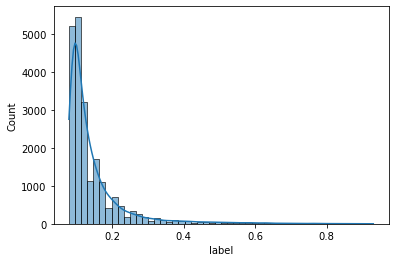

In [80]:
sns.histplot(res['label'], kde=True, bins=50)

Train on entire fraud set we have ->

In [51]:
gmodel = gbt.fit(data)

22/10/06 10:04:36 WARN DAGScheduler: Broadcasting large task binary with size 1021.0 KiB
22/10/06 10:04:36 WARN DAGScheduler: Broadcasting large task binary with size 1059.1 KiB
22/10/06 10:04:37 WARN DAGScheduler: Broadcasting large task binary with size 1042.6 KiB
22/10/06 10:04:37 WARN DAGScheduler: Broadcasting large task binary with size 1043.1 KiB
22/10/06 10:04:37 WARN DAGScheduler: Broadcasting large task binary with size 1043.8 KiB
22/10/06 10:04:37 WARN DAGScheduler: Broadcasting large task binary with size 1044.9 KiB
22/10/06 10:04:37 WARN DAGScheduler: Broadcasting large task binary with size 1047.2 KiB
22/10/06 10:04:37 WARN DAGScheduler: Broadcasting large task binary with size 1051.9 KiB
22/10/06 10:04:37 WARN DAGScheduler: Broadcasting large task binary with size 1060.7 KiB
22/10/06 10:04:37 WARN DAGScheduler: Broadcasting large task binary with size 1077.2 KiB
22/10/06 10:04:38 WARN DAGScheduler: Broadcasting large task binary with size 1103.0 KiB
22/10/06 10:04:38 WAR

In [105]:
pdf['bin'] = pd.cut(pdf['user_fraud_probability'], 20)

<AxesSubplot:xlabel='bin', ylabel='count'>

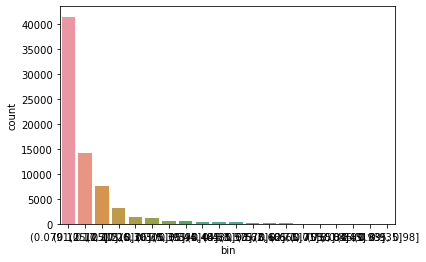

In [106]:
sns.countplot(data=pdf, x='bin')

In [167]:
import math

(71636/pdf.groupby('bin').count()['user_fraud_probability'])

d = pdf.groupby('bin').count()['user_fraud_probability'].map(math.log)
d = d.sum() / d
d

bin
(0.0791, 0.125]     10.621694
(0.125, 0.17]       11.812929
(0.17, 0.215]       12.633793
(0.215, 0.26]       14.000626
(0.26, 0.305]       15.654448
(0.305, 0.35]       16.075901
(0.35, 0.395]       17.532759
(0.395, 0.44]       17.728307
(0.44, 0.485]       19.287135
(0.485, 0.53]       20.041132
(0.53, 0.575]       20.105424
(0.575, 0.62]       20.884774
(0.62, 0.665]       22.987074
(0.665, 0.71]       24.166852
(0.71, 0.755]       28.721407
(0.755, 0.8]        30.409417
(0.8, 0.845]        29.330710
(0.845, 0.89]       51.395549
(0.89, 0.935]       63.026073
(0.935, 0.98]      102.791097
Name: user_fraud_probability, dtype: float64

In [168]:
mapper = (71636/pdf.groupby('bin').count()['user_fraud_probability']).to_dict()
mapper = d.to_dict()

In [128]:
pdf

,dollar_value,rate,gender,revenue,user_fraud_probability,user_fraud_probability_log,dollar_value_log,bin,weights
0,22.82,0.0551,Male,a,0.10,-2.302585,3.127637,"(0.0791, 0.125]",1.729043
1,8.74,0.0293,Female,c,0.19,-1.660731,2.167910,"(0.17, 0.215]",9.401050
2,2378.85,0.0423,Female,b,0.10,-2.302585,7.774372,"(0.0791, 0.125]",1.729043
3,1.90,0.0294,Male,c,0.28,-1.272966,0.641854,"(0.26, 0.305]",52.751105
4,43.54,0.0388,Undisclosed,b,0.09,-2.407946,3.773680,"(0.0791, 0.125]",1.729043
...,...,...,...,...,...,...,...,...,...
71631,256.91,0.0217,Female,c,0.12,-2.120264,5.548726,"(0.0791, 0.125]",1.729043
71632,1885.38,0.0452,Female,b,0.12,-2.120264,7.541885,"(0.0791, 0.125]",1.729043
71633,4100.06,0.0570,Male,a,0.12,-2.120264,8.318757,"(0.0791, 0.125]",1.729043
71634,99.12,0.0407,Female,b,0.09,-2.407946,4.596331,"(0.0791, 0.125]",1.729043


In [169]:
pdf['weights'] = pdf['bin'].map(lambda x: mapper[x])

In [170]:
weighted_df = spark.createDataFrame(pdf.drop('bin', axis=1))

In [171]:
data_w = weighted_df[['dollar_value', 'rate', 'gender', 'revenue', 'user_fraud_probability', 'weights']]

In [172]:
#categorical_cols
data_w = get_dummy(data_w, list(categorical_cols), list(continous_cols), labelCol='user_fraud_probability')


In [173]:
data_w

features,label,weights
"(8,[0,4,6,7],[1.0...",0.1,10.621693938062911
"(8,[2,5,6,7],[1.0...",0.19,12.633793472863506
"(8,[1,5,6,7],[1.0...",0.1,10.621693938062911
"(8,[2,4,6,7],[1.0...",0.28,15.65444826845813
"(8,[1,6,7],[1.0,4...",0.09,10.621693938062911
"(8,[1,5,6,7],[1.0...",0.14,11.812928770706218
"(8,[2,6,7],[1.0,2...",0.09,10.621693938062911
"(8,[0,4,6,7],[1.0...",0.09,10.621693938062911
"(8,[2,4,6,7],[1.0...",0.17,12.633793472863506
"(8,[1,4,6,7],[1.0...",0.14,11.812928770706218


In [174]:
gbt = GBTRegressor(labelCol='label',
                   #featuresCol="features_std",
                   featuresCol="features",
                   maxIter=20,
                   maxDepth=10,
                   seed=56,
                   lossType='squared',
                   weightCol='weights')

In [175]:
(trainingData, testData) = data_w.randomSplit([0.7, 0.3])

In [176]:
model = gbt.fit(trainingData)

22/10/06 12:27:11 WARN DAGScheduler: Broadcasting large task binary with size 1022.1 KiB
22/10/06 12:27:11 WARN DAGScheduler: Broadcasting large task binary with size 1012.1 KiB
22/10/06 12:27:11 WARN DAGScheduler: Broadcasting large task binary with size 1012.6 KiB
22/10/06 12:27:11 WARN DAGScheduler: Broadcasting large task binary with size 1013.3 KiB
22/10/06 12:27:11 WARN DAGScheduler: Broadcasting large task binary with size 1014.4 KiB
22/10/06 12:27:12 WARN DAGScheduler: Broadcasting large task binary with size 1016.7 KiB
22/10/06 12:27:12 WARN DAGScheduler: Broadcasting large task binary with size 1021.6 KiB
22/10/06 12:27:12 WARN DAGScheduler: Broadcasting large task binary with size 1030.8 KiB
22/10/06 12:27:12 WARN DAGScheduler: Broadcasting large task binary with size 1046.7 KiB
22/10/06 12:27:12 WARN DAGScheduler: Broadcasting large task binary with size 1071.4 KiB
22/10/06 12:27:12 WARN DAGScheduler: Broadcasting large task binary with size 1109.4 KiB
22/10/06 12:27:12 WAR

In [183]:
predictions = model.transform(trainingData)

In [184]:
rmse_evaluator = RegressionEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="rmse")
rmse = rmse_evaluator.evaluate(predictions)

mae_evaluator = RegressionEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="mae")
mae = mae_evaluator.evaluate(predictions)

print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print("Mean Average Error (MAE) on test data = %g" % mae)

Root Mean Squared Error (RMSE) on test data = 0.0756033
Mean Average Error (MAE) on test data = 0.0489029


In [185]:
res = predictions.select(['prediction', 'label']).toPandas()

<AxesSubplot:>

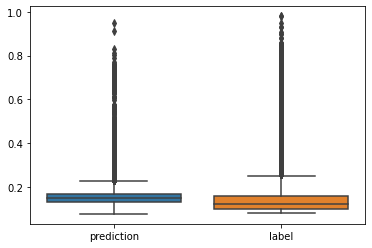

In [186]:
sns.boxplot(data=res)

<AxesSubplot:xlabel='prediction', ylabel='Count'>

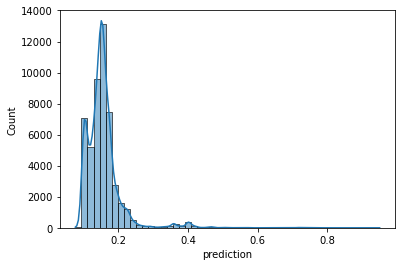

In [187]:
#sns.histplot(x='prediction', data=res[res['prediction'] <= 1], kde=True)
sns.histplot(x='prediction', data=res, kde=True, bins=50)

<AxesSubplot:xlabel='label', ylabel='Count'>

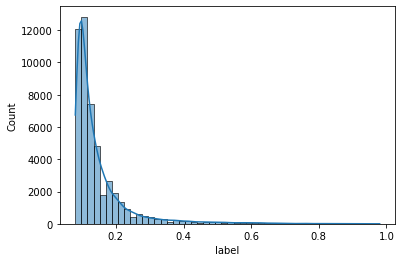

In [188]:
sns.histplot(res['label'], kde=True, bins=50)